# Bike Sharing Demand Prediction Model

This notebook implements a comprehensive model to predict bike sharing demand using various machine learning techniques. We'll go through data preprocessing, feature engineering, exploratory data analysis, model training, and evaluation.

In [1]:
# Bike Sharing Demand Prediction Model
# This script implements a comprehensive model to predict bike sharing demand

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

## 1. Data Loading and Preprocessing

In this section, we load the bike sharing datasets, check for missing values, and perform initial data inspection.

In [59]:
# Function to calculate RMSLE (Root Mean Squared Logarithmic Error)
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

# Load the datasets
print("Loading datasets...")
train_data = pd.read_csv('../Data/train.csv')
test_data = pd.read_csv('../Data/test.csv')

# Display basic information
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Check for missing values
print("\nMissing values in train data:")
print(train_data.isnull().sum())
print("\nMissing values in test data:")
print(test_data.isnull().sum())

# Convert datetime to proper format
train_data['datetime'] = pd.to_datetime(train_data['datetime'])
test_data['datetime'] = pd.to_datetime(test_data['datetime'])

Loading datasets...
Train data shape: (10886, 12)
Test data shape: (6493, 9)

Missing values in train data:
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

Missing values in test data:
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


## 2. Feature Engineering

Feature engineering is crucial for improving model performance. We extract datetime features, create interaction terms, and generate domain-specific features related to weather conditions and biking comfort.

In [60]:
# Extract date-time features
def extract_datetime_features(df):
    # Basic datetime features
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    
    # Derived datetime features
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['quarter'] = df['datetime'].dt.quarter
    df['dayofyear'] = df['datetime'].dt.dayofyear
    df['weekofyear'] = df['datetime'].dt.isocalendar().week
    
    # Time period categories
    time_periods = {
        'night': (0, 6),
        'morning': (6, 12),
        'afternoon': (12, 18),
        'evening': (18, 24)
    }
    
    # Create time of day feature
    conditions = [
        (df['hour'] >= time_periods['night'][0]) & (df['hour'] < time_periods['night'][1]),
        (df['hour'] >= time_periods['morning'][0]) & (df['hour'] < time_periods['morning'][1]),
        (df['hour'] >= time_periods['afternoon'][0]) & (df['hour'] < time_periods['afternoon'][1]),
        (df['hour'] >= time_periods['evening'][0]) & (df['hour'] < time_periods['evening'][1])
    ]
    choices = ['night', 'morning', 'afternoon', 'evening']
    df['time_of_day'] = np.select(conditions, choices, default='unknown')
    
    # Create cyclic features for time variables
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['day_sin'] = np.sin(2 * np.pi * df['day']/31)
    df['day_cos'] = np.cos(2 * np.pi * df['day']/31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)
    
    # Rush hour flags
    morning_rush = (df['hour'] >= 7) & (df['hour'] <= 9)
    evening_rush = (df['hour'] >= 16) & (df['hour'] <= 19)
    df['is_rush_hour'] = (morning_rush | evening_rush).astype(int)

    # Weekend rush hour (different pattern on weekends)
    weekend_noon_rush = (df['hour'] >= 11) & (df['hour'] <= 14)
    weekend_evening_rush = (df['hour'] >= 16) & (df['hour'] <= 20)
    df['is_weekend_rush'] = ((df['is_weekend'] == 1) & (weekend_noon_rush | weekend_evening_rush)).astype(int)
    
    return df

print("Extracting datetime features...")
train_data = extract_datetime_features(train_data)
test_data = extract_datetime_features(test_data)

# Feature engineering
def feature_engineering(df):
    # Interaction features
    df['temp_humidity'] = df['temp'] * df['humidity']
    df['temp_windspeed'] = df['temp'] * df['windspeed']
    df['humidity_windspeed'] = df['humidity'] * df['windspeed']
    df['atemp_humidity'] = df['atemp'] * df['humidity']
    df['atemp_windspeed'] = df['atemp'] * df['windspeed']
    
    # Temperature difference (feels like vs actual)
    df['temp_diff'] = df['atemp'] - df['temp']
    
    # Weather severity
    weather_severity_map = {1: 1, 2: 2, 3: 3, 4: 4}
    df['weather_severity'] = df['weather'].map(weather_severity_map)
    
    # Extreme weather conditions
    df['is_extreme_temp'] = ((df['temp'] < 0.2) | (df['temp'] > 0.8)).astype(int)
    df['is_extreme_humidity'] = ((df['humidity'] < 0.2) | (df['humidity'] > 0.8)).astype(int)
    df['is_extreme_windspeed'] = (df['windspeed'] > 0.5).astype(int)
    df['is_bad_weather'] = (df['weather'] >= 3).astype(int)
    
    # Ideal biking condition (moderate temp, low humidity, low windspeed, good weather)
    df['ideal_biking_condition'] = (((df['temp'] >= 0.4) & (df['temp'] <= 0.7)) & 
                                  (df['humidity'] < 0.6) & 
                                  (df['windspeed'] < 0.3) & 
                                  (df['weather'] <= 2)).astype(int)
    
    # Comfort metrics
    df['comfort_index'] = df['temp'] - 0.1 * df['humidity'] - 0.1 * df['windspeed']
    
    # Season-based features
    df['is_summer'] = (df['season'] == 2).astype(int)
    df['is_fall'] = (df['season'] == 3).astype(int)
    df['is_winter'] = (df['season'] == 4).astype(int)
    df['is_spring'] = (df['season'] == 1).astype(int)
    
    # Holiday and working day interaction
    df['free_day'] = ((df['holiday'] == 1) | (df['is_weekend'] == 1)).astype(int)
    
    return df

print("Applying feature engineering...")
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

Extracting datetime features...
Applying feature engineering...


## 3. Exploratory Data Analysis

Exploratory Data Analysis helps us understand patterns in the data. We visualize rental distributions, temporal patterns, and relationships between features.


Performing Exploratory Data Analysis...


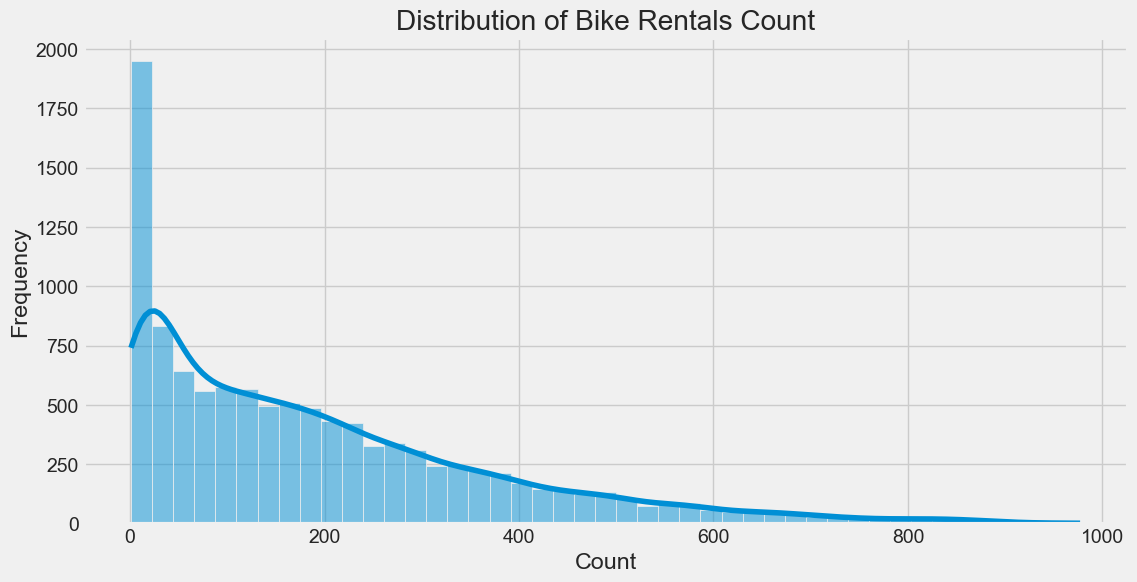

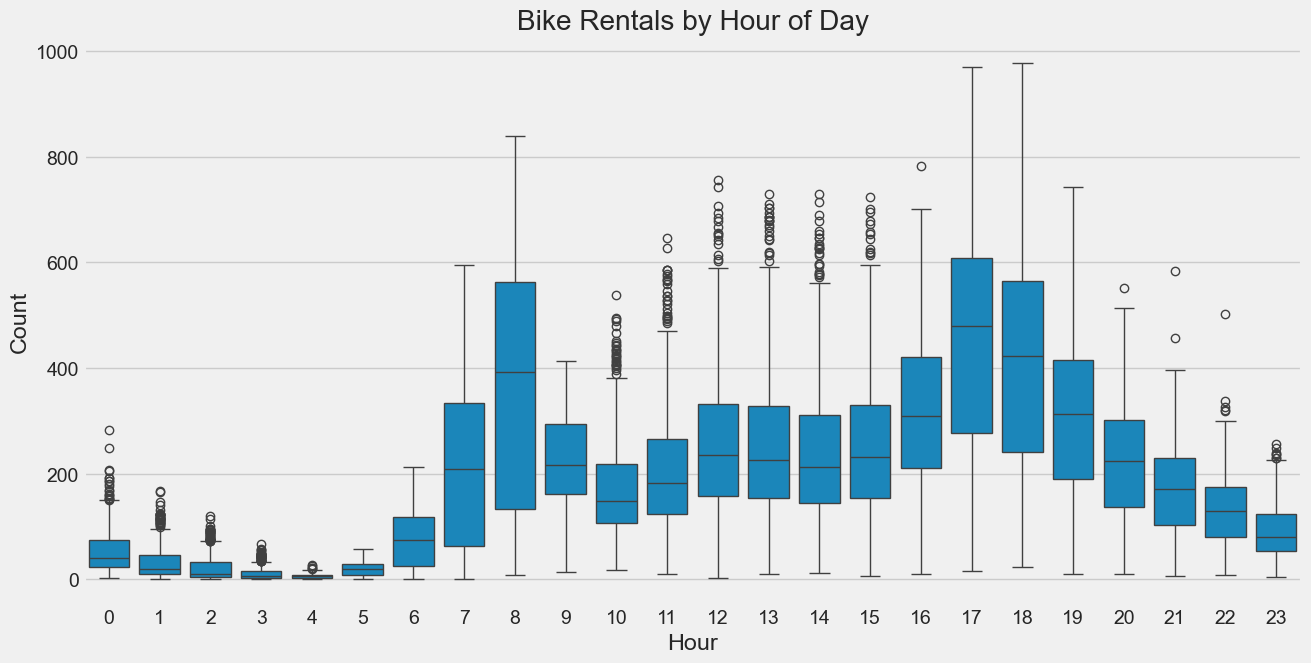

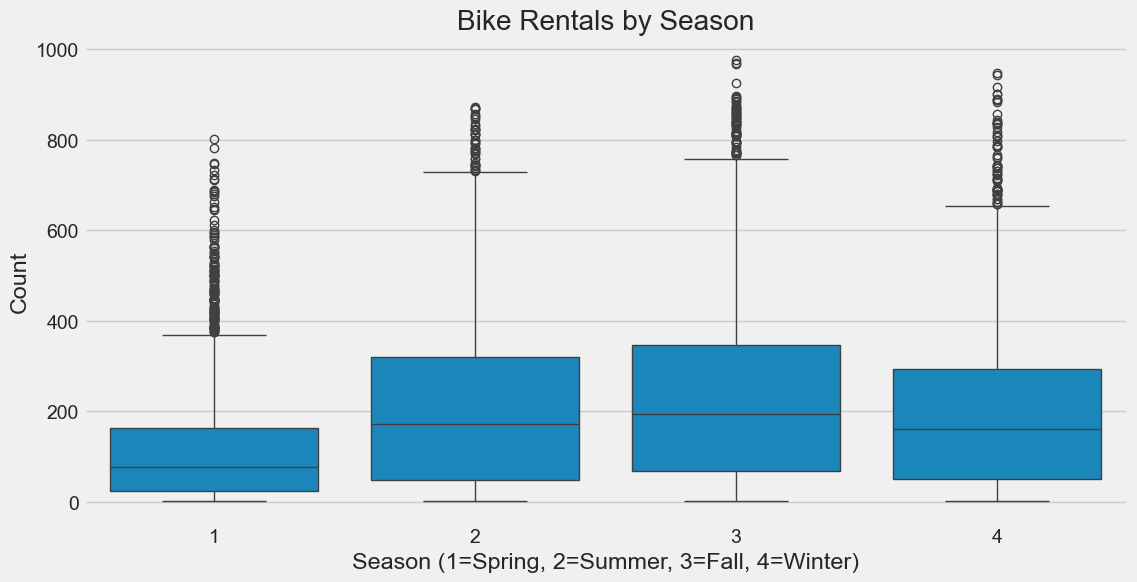

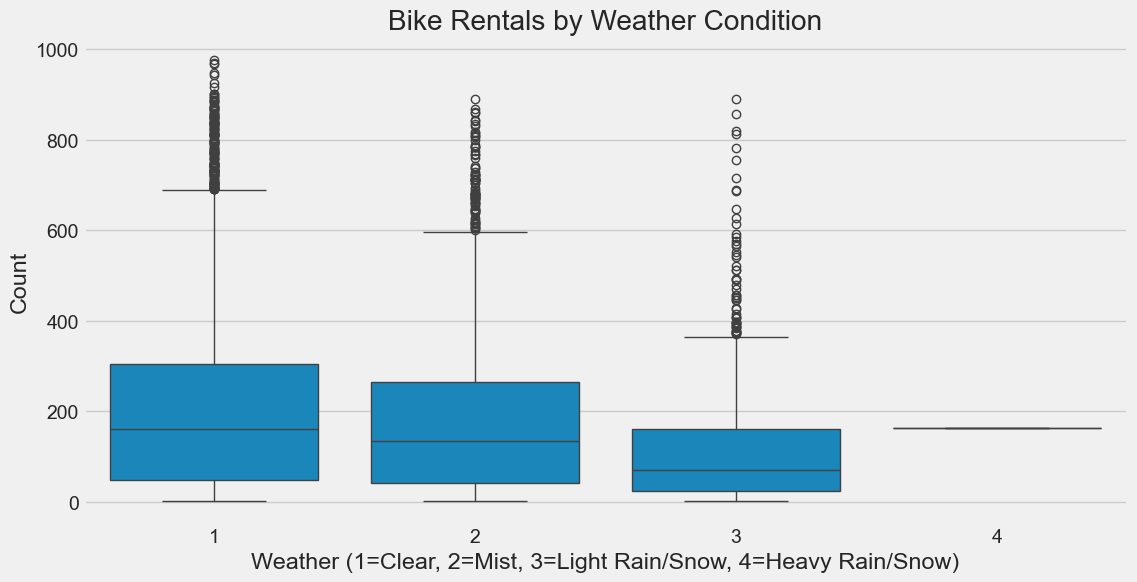

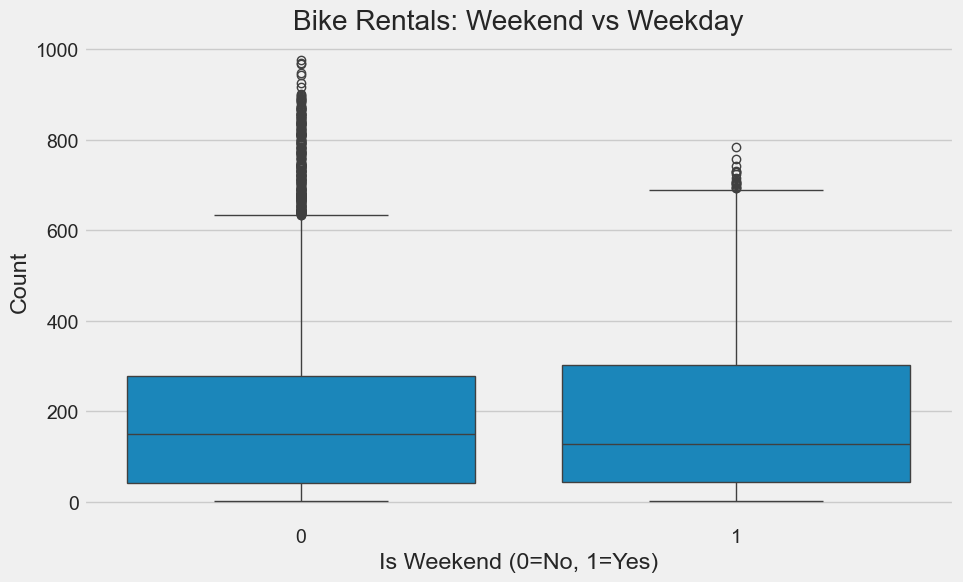

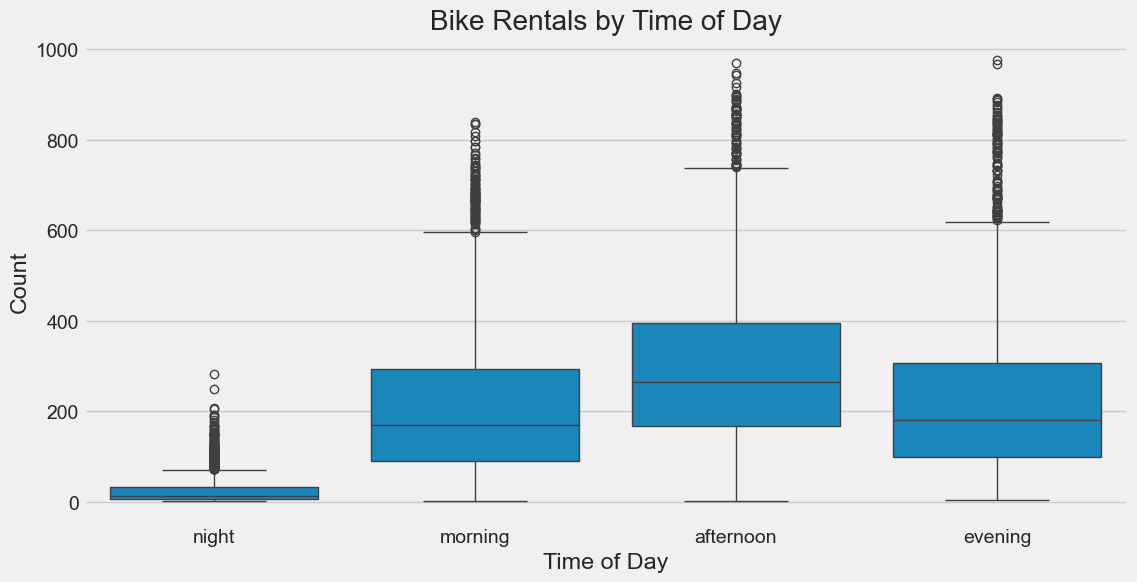

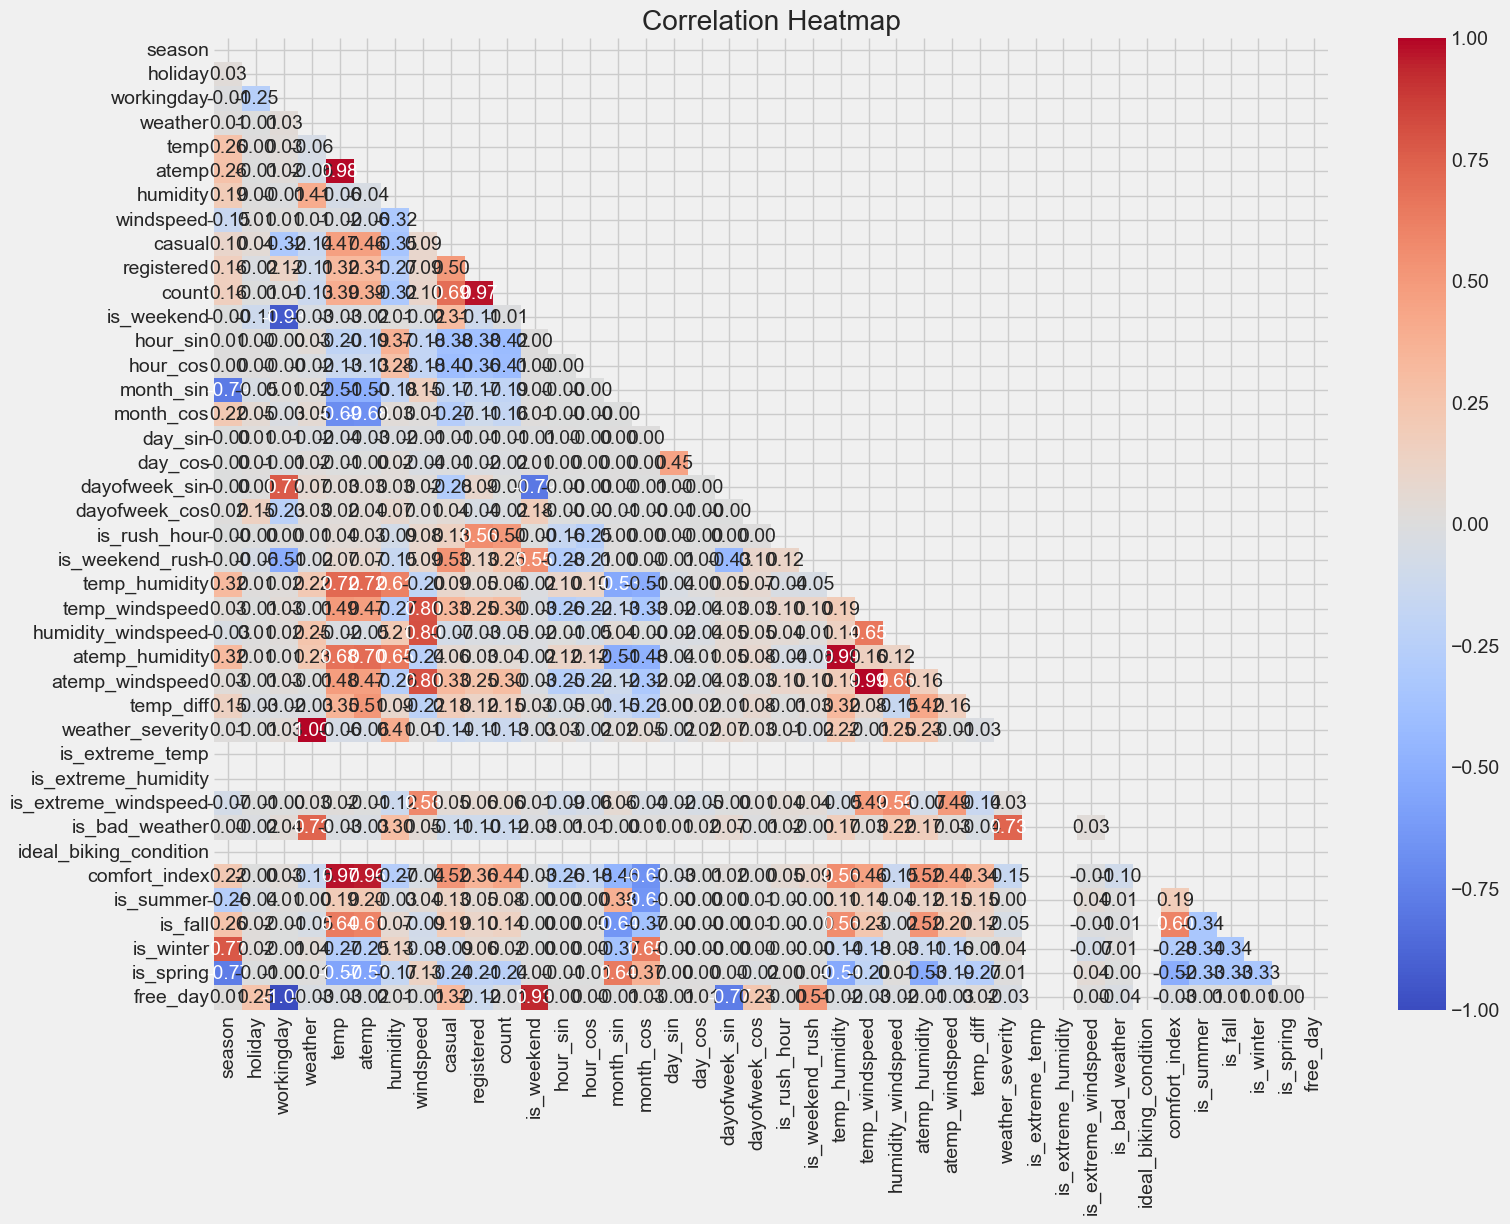

In [44]:
# Perform Exploratory Data Analysis
print("\nPerforming Exploratory Data Analysis...")

# Distribution of bike rentals
plt.figure(figsize=(12, 6))
sns.histplot(train_data['count'], kde=True)
plt.title('Distribution of Bike Rentals Count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.savefig('../count_distribution.png')
plt.show()

# Hourly rental patterns
plt.figure(figsize=(14, 7))
sns.boxplot(x='hour', y='count', data=train_data)
plt.title('Bike Rentals by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.savefig('../hourly_rentals.png')
plt.show()

# Seasonal rental patterns
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='count', data=train_data)
plt.title('Bike Rentals by Season')
plt.xlabel('Season (1=Spring, 2=Summer, 3=Fall, 4=Winter)')
plt.ylabel('Count')
plt.savefig('../seasonal_rentals.png')
plt.show()

# Weather impact on rentals
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather', y='count', data=train_data)
plt.title('Bike Rentals by Weather Condition')
plt.xlabel('Weather (1=Clear, 2=Mist, 3=Light Rain/Snow, 4=Heavy Rain/Snow)')
plt.ylabel('Count')
plt.savefig('../weather_impact.png')
plt.show()

# Weekend vs Weekday
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_weekend', y='count', data=train_data)
plt.title('Bike Rentals: Weekend vs Weekday')
plt.xlabel('Is Weekend (0=No, 1=Yes)')
plt.ylabel('Count')
plt.savefig('../weekend_weekday.png')
plt.show()

# Time of day impact
plt.figure(figsize=(12, 6))
sns.boxplot(x='time_of_day', y='count', data=train_data)
plt.title('Bike Rentals by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.savefig('../time_of_day.png')
plt.show()

# Correlation heatmap
plt.figure(figsize=(16, 12))
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
correlation = train_data[numerical_cols].corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Heatmap')
plt.savefig('../correlation_heatmap.png')
plt.show()

### Visualization Results

#### Count Distribution

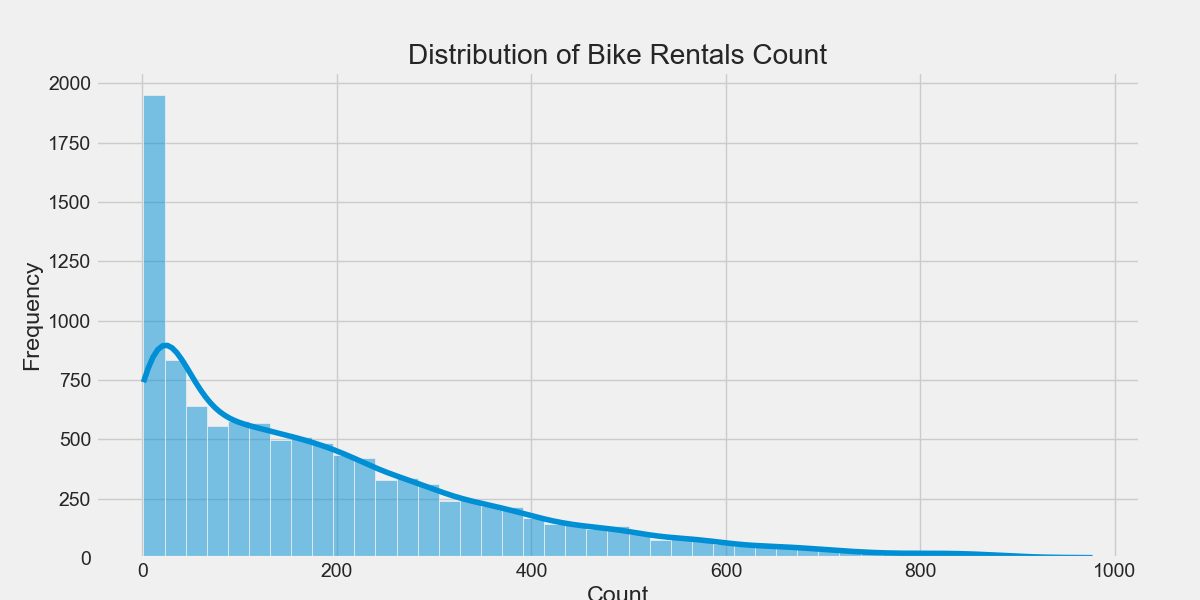

In [45]:
from IPython.display import Image
Image(filename='../count_distribution.png', width=800)

#### Hourly Rentals

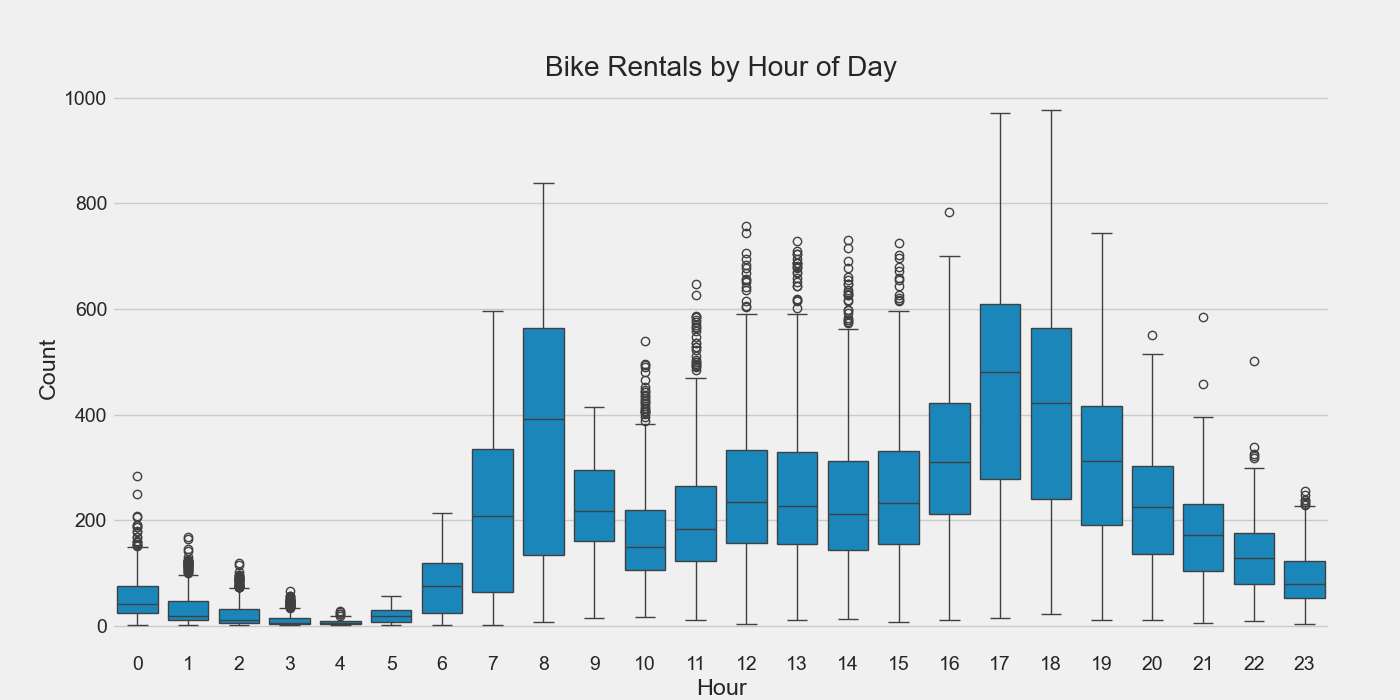

In [46]:
from IPython.display import Image
Image(filename='../hourly_rentals.png', width=800)

#### Seasonal Rentals

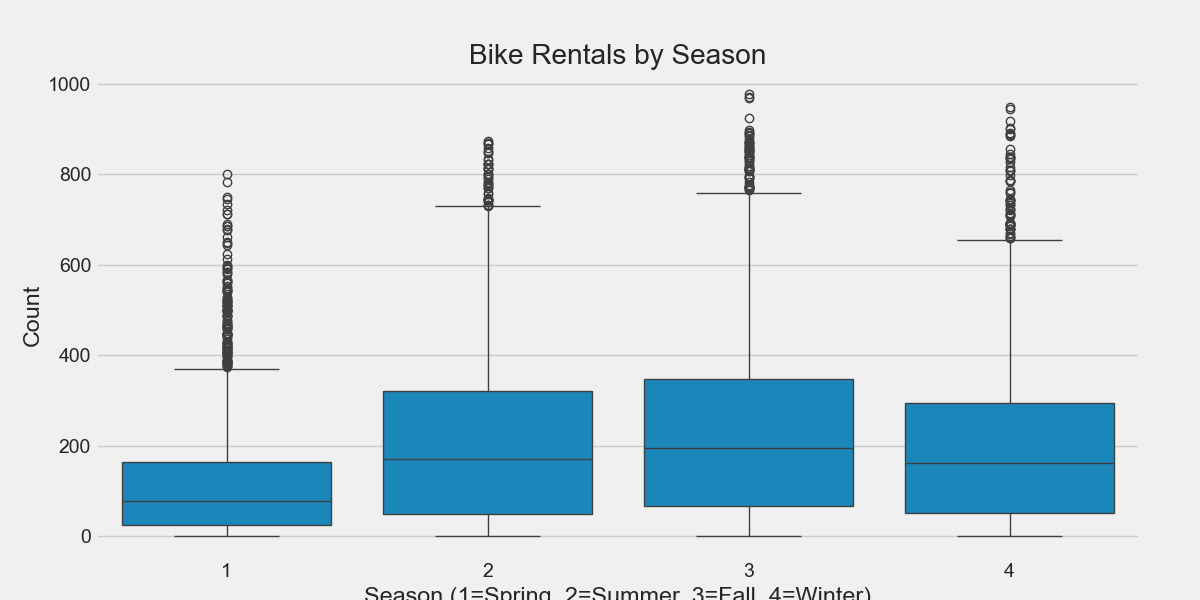

In [47]:
from IPython.display import Image
Image(filename='../seasonal_rentals.png', width=800)

#### Weather Impact

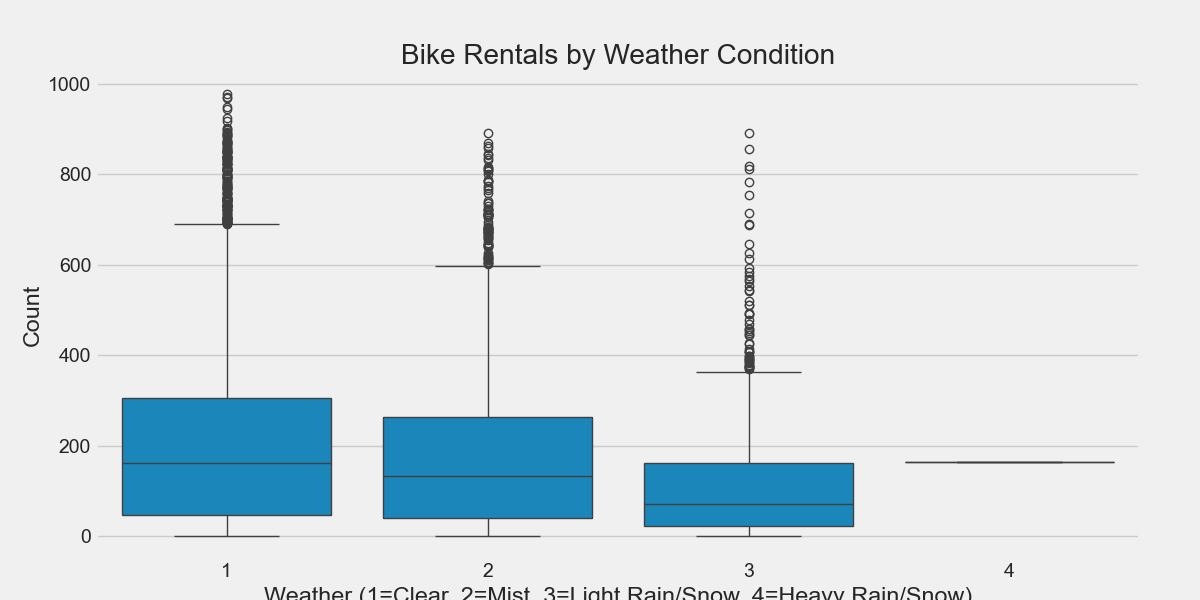

In [48]:
from IPython.display import Image
Image(filename='../weather_impact.png', width=800)

#### Weekend Weekday

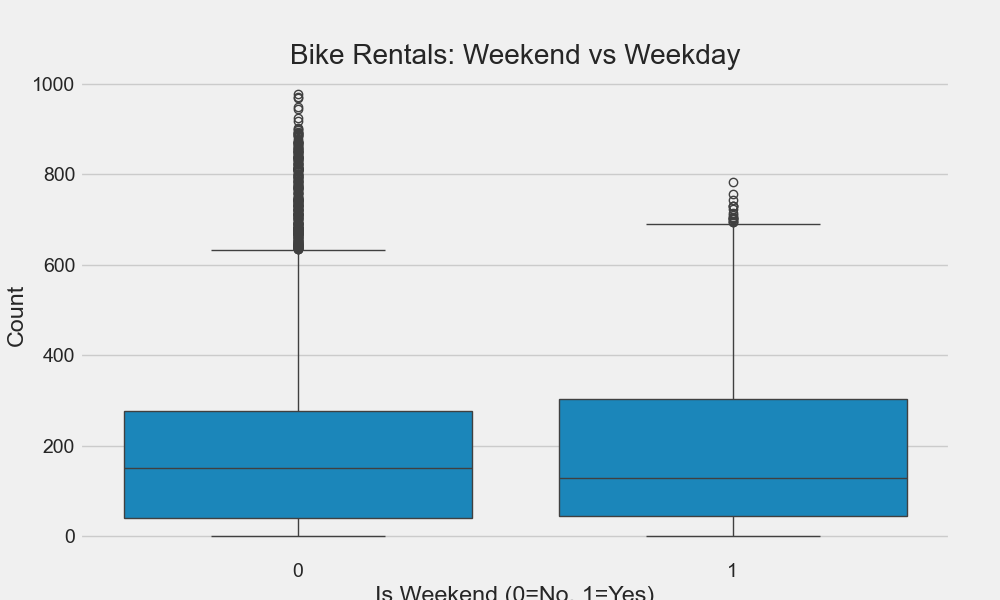

In [49]:
from IPython.display import Image
Image(filename='../weekend_weekday.png', width=800)

#### Time Of Day

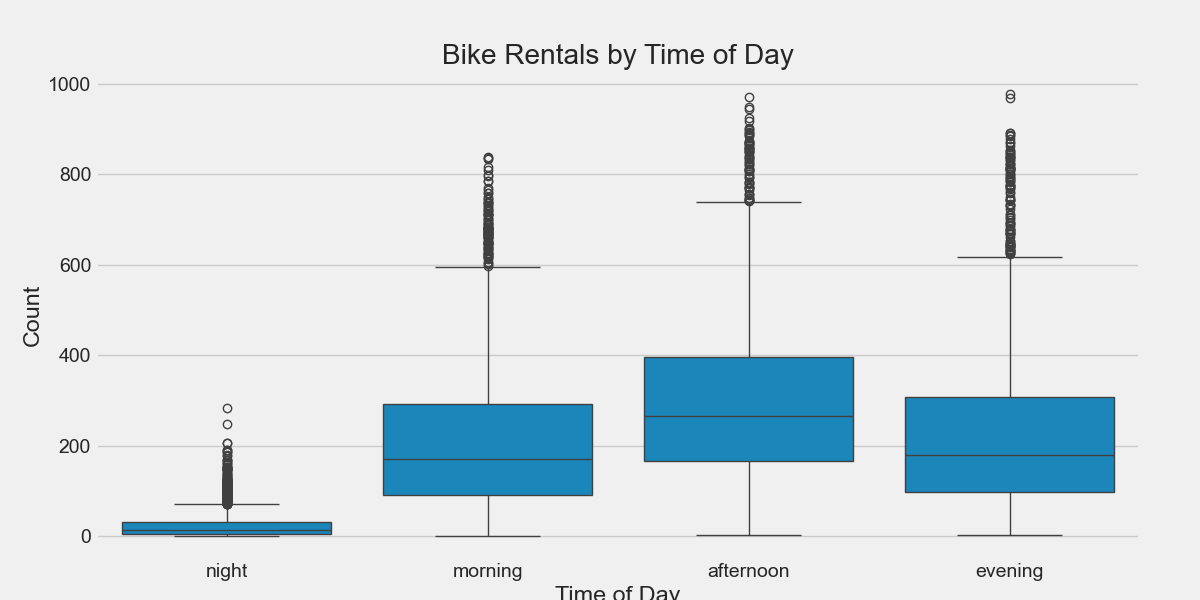

In [50]:
from IPython.display import Image
Image(filename='../time_of_day.png', width=800)

#### Correlation Heatmap

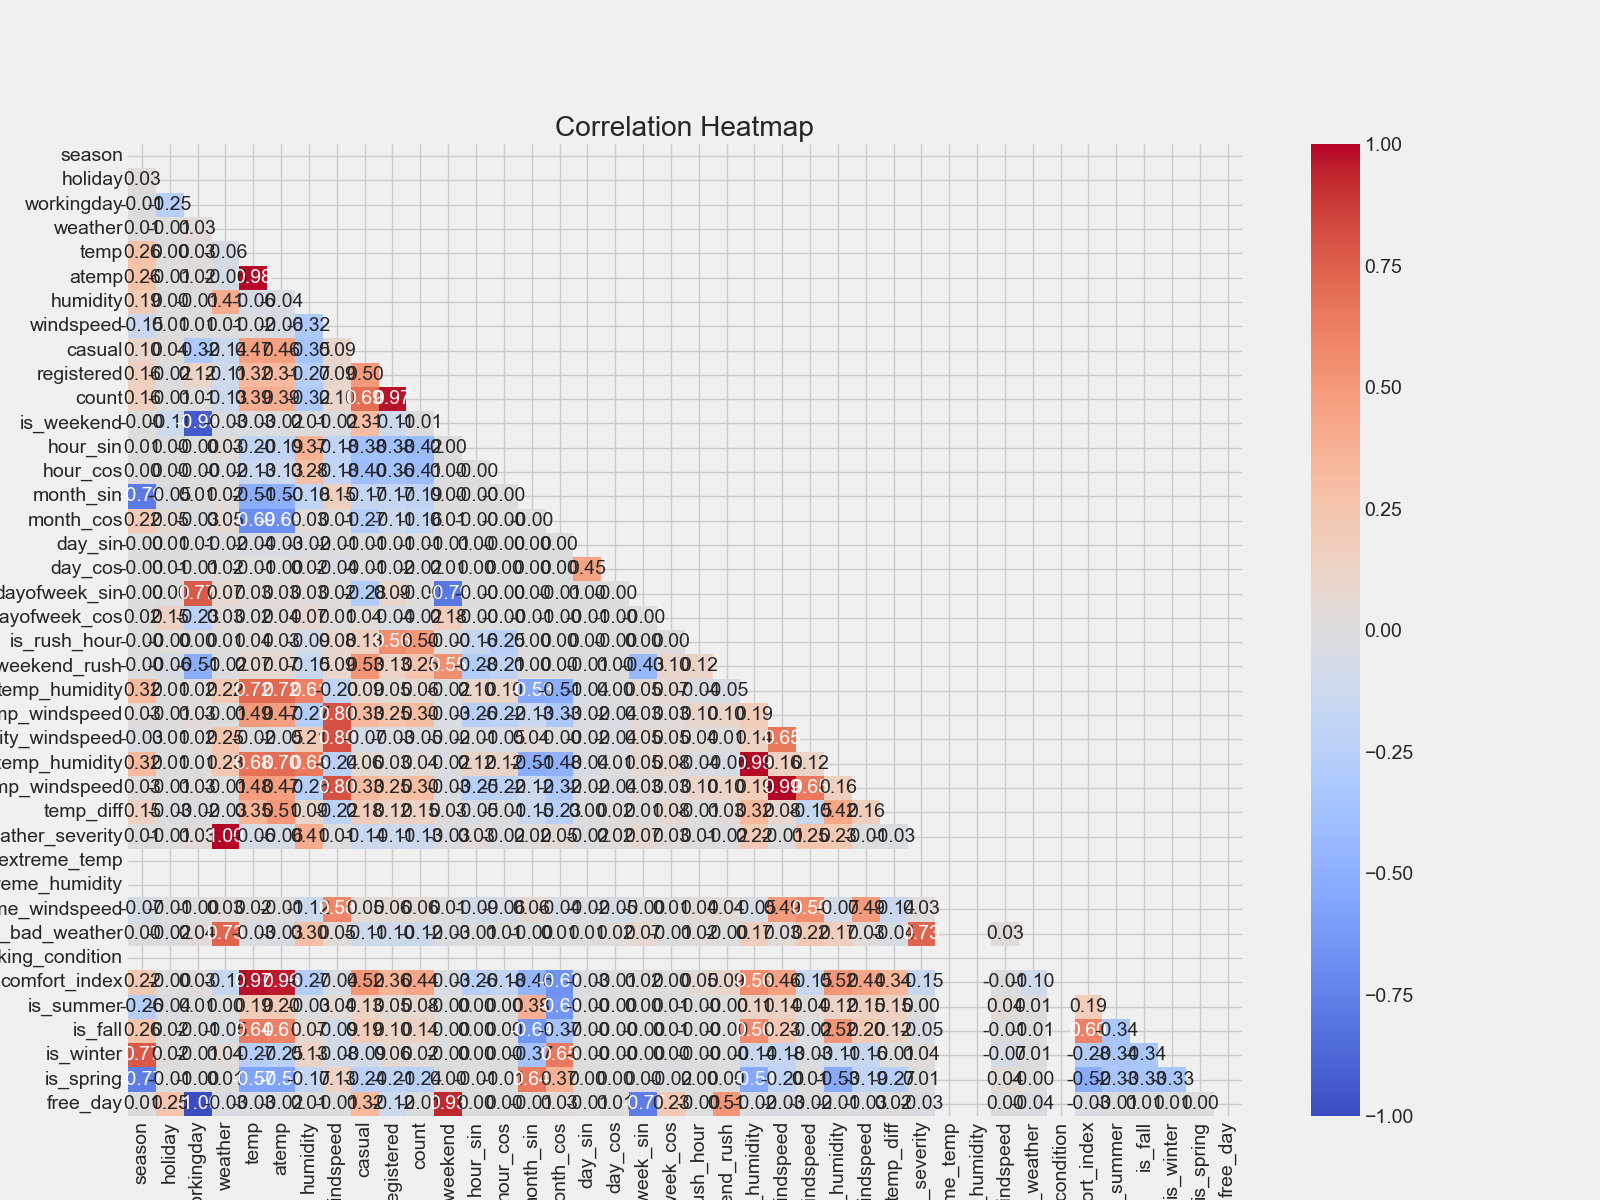

In [51]:
from IPython.display import Image
Image(filename='../correlation_heatmap.png', width=800)

## 4. Model Training and Evaluation

We train multiple regression models including Linear Regression, Ridge Regression, Random Forest, and Gradient Boosting. Each model is evaluated using RMSLE, RMSE, and R² metrics.

In [52]:
# Prepare data for modeling
print("\nPreparing data for modeling...")

# Define features to use
features = [
    'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
    'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend', 'quarter',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos',
    'is_rush_hour', 'is_weekend_rush', 'temp_humidity', 'temp_windspeed', 'humidity_windspeed',
    'atemp_humidity', 'atemp_windspeed', 'temp_diff', 'weather_severity',
    'is_extreme_temp', 'is_extreme_humidity', 'is_extreme_windspeed', 'is_bad_weather',
    'ideal_biking_condition', 'comfort_index', 'is_summer', 'is_fall', 'is_winter', 'is_spring', 'free_day'
]

# Prepare training data
X = train_data[features]
y = train_data['count']

# Log transform the target variable
y_log = np.log1p(y)

# Split the data into training and validation sets
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# Get the original y values for evaluation
y_train = np.expm1(y_train_log)
y_val = np.expm1(y_val_log)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train models
print("\nTraining models...")

# Define constants for model names
LINEAR_REGRESSION = 'Linear Regression'
RIDGE_REGRESSION = 'Ridge Regression'
RANDOM_FOREST = 'Random Forest'
GRADIENT_BOOSTING = 'Gradient Boosting'

# Linear Regression
print("Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_log)
lr_pred = np.expm1(lr.predict(X_val_scaled))
print(f"Linear Regression RMSLE: {rmsle(y_val, lr_pred):.4f}")
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_val, lr_pred)):.4f}")
print(f"Linear Regression R²: {r2_score(y_val, lr_pred):.4f}")

# Ridge Regression
print("\nTraining Ridge Regression...")
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train_log)
ridge_pred = np.expm1(ridge.predict(X_val_scaled))
print(f"Ridge Regression RMSLE: {rmsle(y_val, ridge_pred):.4f}")
print(f"Ridge Regression RMSE: {np.sqrt(mean_squared_error(y_val, ridge_pred)):.4f}")
print(f"Ridge Regression R²: {r2_score(y_val, ridge_pred):.4f}")

# Random Forest
print("\nTraining Random Forest...")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train_log)
rf_pred = np.expm1(rf.predict(X_val))
print(f"Random Forest RMSLE: {rmsle(y_val, rf_pred):.4f}")
print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_val, rf_pred)):.4f}")
print(f"Random Forest R²: {r2_score(y_val, rf_pred):.4f}")

# Gradient Boosting
print("\nTraining Gradient Boosting...")
gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train, y_train_log)
gb_pred = np.expm1(gb.predict(X_val))
print(f"Gradient Boosting RMSLE: {rmsle(y_val, gb_pred):.4f}")
print(f"Gradient Boosting RMSE: {np.sqrt(mean_squared_error(y_val, gb_pred)):.4f}")
print(f"Gradient Boosting R²: {r2_score(y_val, gb_pred):.4f}")


Preparing data for modeling...

Training models...
Training Linear Regression...
Linear Regression RMSLE: 0.7470
Linear Regression RMSE: 127.5259
Linear Regression R²: 0.5073

Training Ridge Regression...
Ridge Regression RMSLE: 0.7471
Ridge Regression RMSE: 127.4852
Ridge Regression R²: 0.5076

Training Random Forest...
Random Forest RMSLE: 0.3147
Random Forest RMSE: 43.9174
Random Forest R²: 0.9416

Training Gradient Boosting...
Gradient Boosting RMSLE: 0.2873
Gradient Boosting RMSE: 39.9382
Gradient Boosting R²: 0.9517


## 5. Model Comparison and Ensemble

We compare all models and create a weighted ensemble to potentially improve prediction performance.


Model Comparison:
               Model     RMSLE        RMSE        R²
3  Gradient Boosting  0.287346   39.938233  0.951675
2      Random Forest  0.314734   43.917367  0.941566
0  Linear Regression  0.747046  127.525859  0.507290
1   Ridge Regression  0.747057  127.485202  0.507604


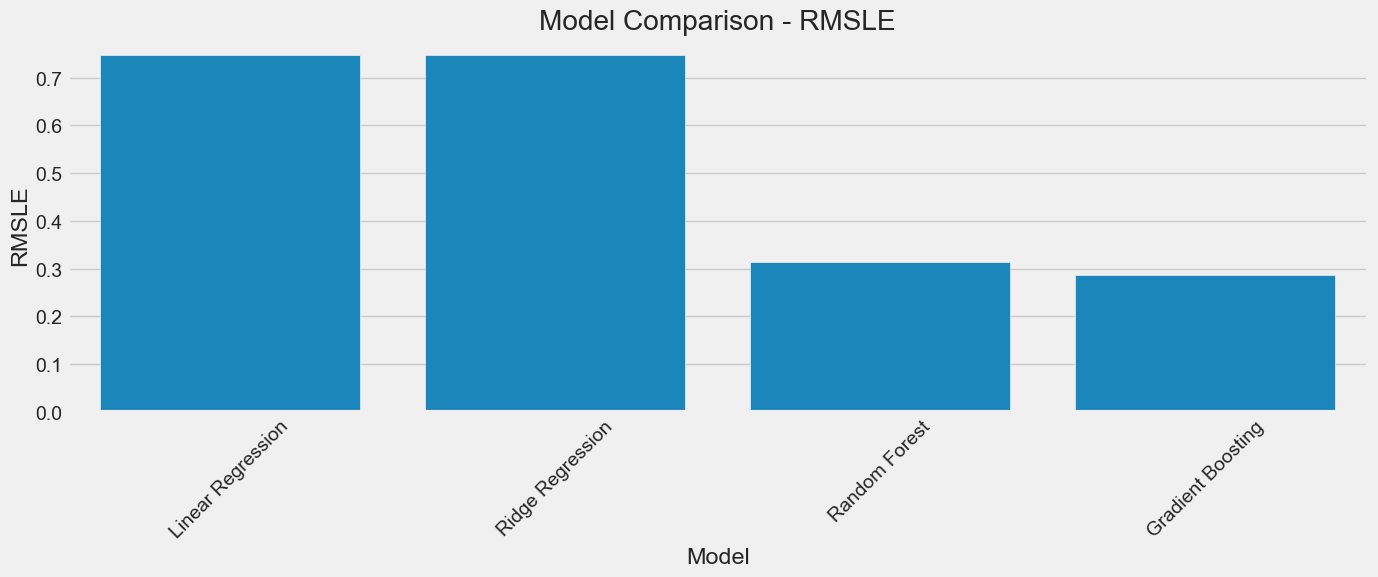


Best model based on RMSLE: Gradient Boosting

Creating ensemble model...
Top 3 models for ensemble: ['Gradient Boosting' 'Random Forest' 'Linear Regression']
Weighted Ensemble RMSLE: 0.3305
Weighted Ensemble RMSE: 46.7954
Weighted Ensemble R²: 0.9337


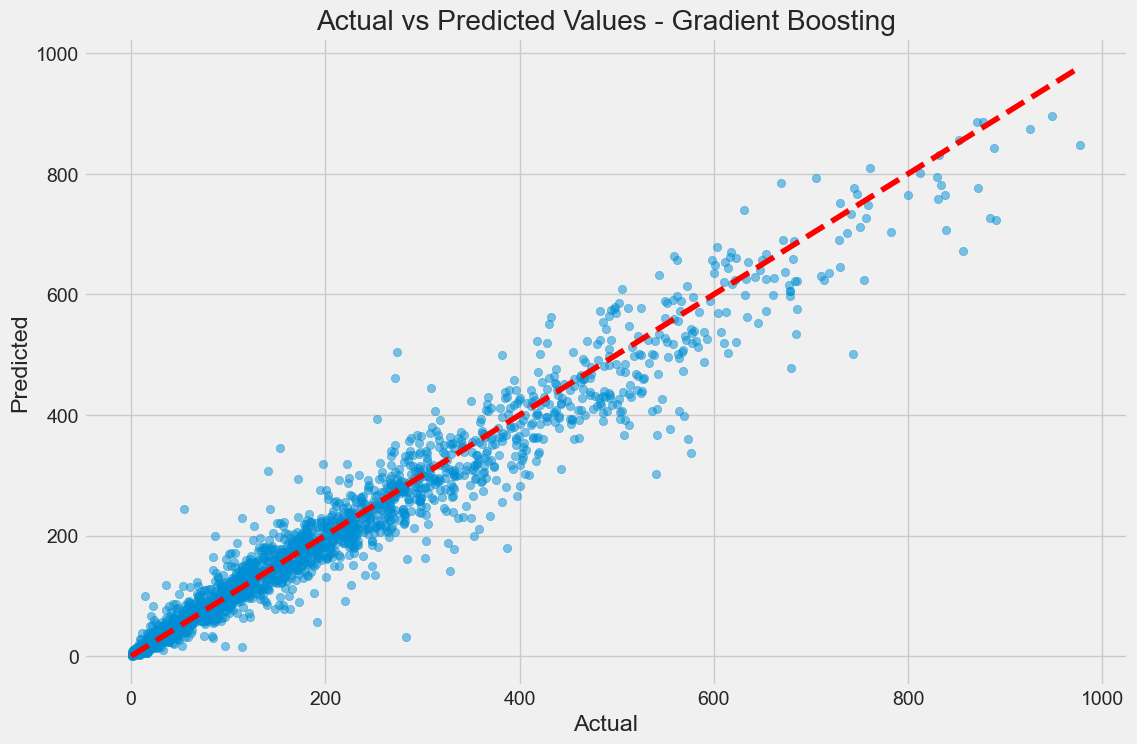

In [53]:
# Compare models
models = [
    LINEAR_REGRESSION,
    RIDGE_REGRESSION,
    RANDOM_FOREST,
    GRADIENT_BOOSTING
]

rmsle_scores = [
    rmsle(y_val, lr_pred),
    rmsle(y_val, ridge_pred),
    rmsle(y_val, rf_pred),
    rmsle(y_val, gb_pred)
]

rmse_scores = [
    np.sqrt(mean_squared_error(y_val, lr_pred)),
    np.sqrt(mean_squared_error(y_val, ridge_pred)),
    np.sqrt(mean_squared_error(y_val, rf_pred)),
    np.sqrt(mean_squared_error(y_val, gb_pred))
]

r2_scores = [
    r2_score(y_val, lr_pred),
    r2_score(y_val, ridge_pred),
    r2_score(y_val, rf_pred),
    r2_score(y_val, gb_pred)
]

model_comparison = pd.DataFrame({
    'Model': models,
    'RMSLE': rmsle_scores,
    'RMSE': rmse_scores,
    'R²': r2_scores
})

print("\nModel Comparison:")
print(model_comparison.sort_values('RMSLE'))

# Plot model comparison
plt.figure(figsize=(14, 6))
sns.barplot(x='Model', y='RMSLE', data=model_comparison)
plt.title('Model Comparison - RMSLE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../model_comparison.png')
plt.show()

# Get the best model
best_model_idx = np.argmin(rmsle_scores)
best_model_name = models[best_model_idx]
print(f"\nBest model based on RMSLE: {best_model_name}")

# Create ensemble model
print("\nCreating ensemble model...")

# Sort models by RMSLE and select top 3
top_models_idx = np.argsort(rmsle_scores)[:3]
top_models = np.array(models)[top_models_idx]
print(f"Top 3 models for ensemble: {top_models}")

# Assign weights based on inverse of RMSLE
weights = 1 / np.array(rmsle_scores)[top_models_idx]
weights = weights / np.sum(weights)

# Prepare individual predictions based on model names
model_predictions = {
    LINEAR_REGRESSION: lr_pred,
    RIDGE_REGRESSION: ridge_pred,
    RANDOM_FOREST: rf_pred,
    GRADIENT_BOOSTING: gb_pred
}

# Calculate ensemble prediction using weights and model predictions
ensemble_pred = sum(weights[i] * model_predictions[top_models[i]] for i in range(len(top_models)))

# Evaluate ensemble model
print(f"Weighted Ensemble RMSLE: {rmsle(y_val, ensemble_pred):.4f}")
print(f"Weighted Ensemble RMSE: {np.sqrt(mean_squared_error(y_val, ensemble_pred)):.4f}")
print(f"Weighted Ensemble R²: {r2_score(y_val, ensemble_pred):.4f}")

# Plot actual vs predicted values for the best model
plt.figure(figsize=(12, 8))
plt.scatter(y_val, model_predictions[best_model_name], alpha=0.5)
plt.plot([0, max(y_val)], [0, max(y_val)], 'r--')
plt.title(f'Actual vs Predicted Values - {best_model_name}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig('../actual_vs_predicted.png')
plt.show()

### Model Comparison Visualization

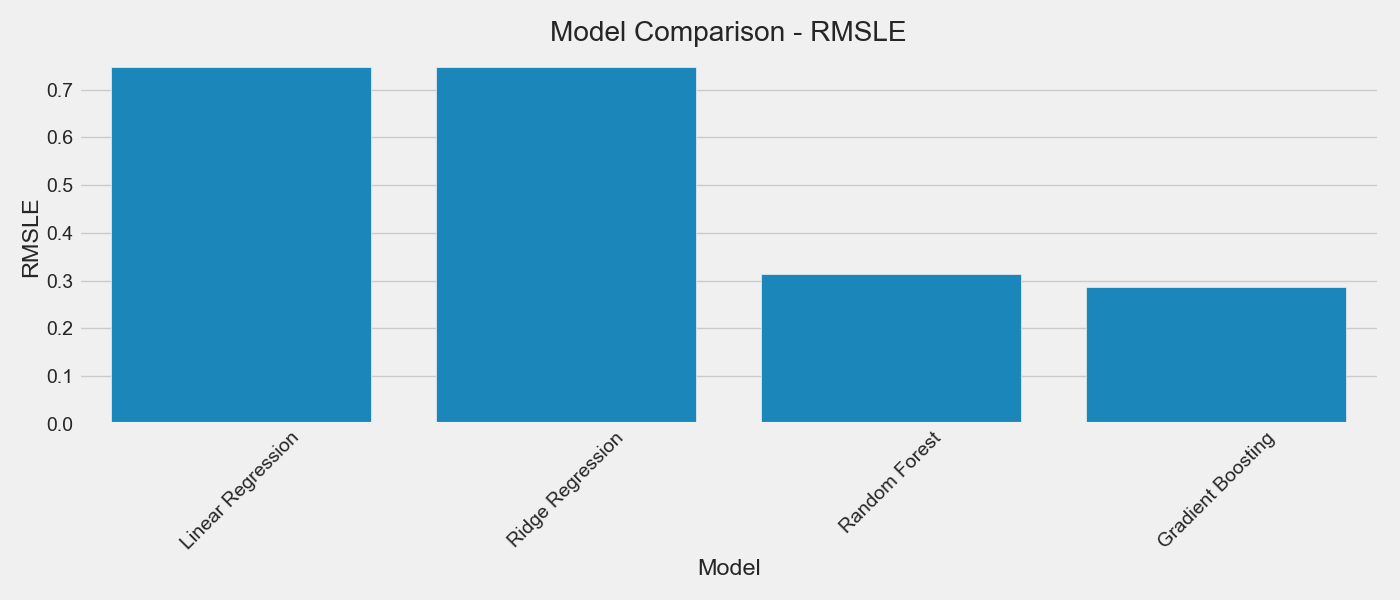

In [54]:
from IPython.display import Image
Image(filename='../model_comparison.png', width=800)

## 6. Final Predictions and Feature Importance

Using the best performing model, we generate predictions for the test dataset and analyze feature importance.


Final model: Gradient Boosting

Predictions saved to 'bike_sharing_predictions.csv'


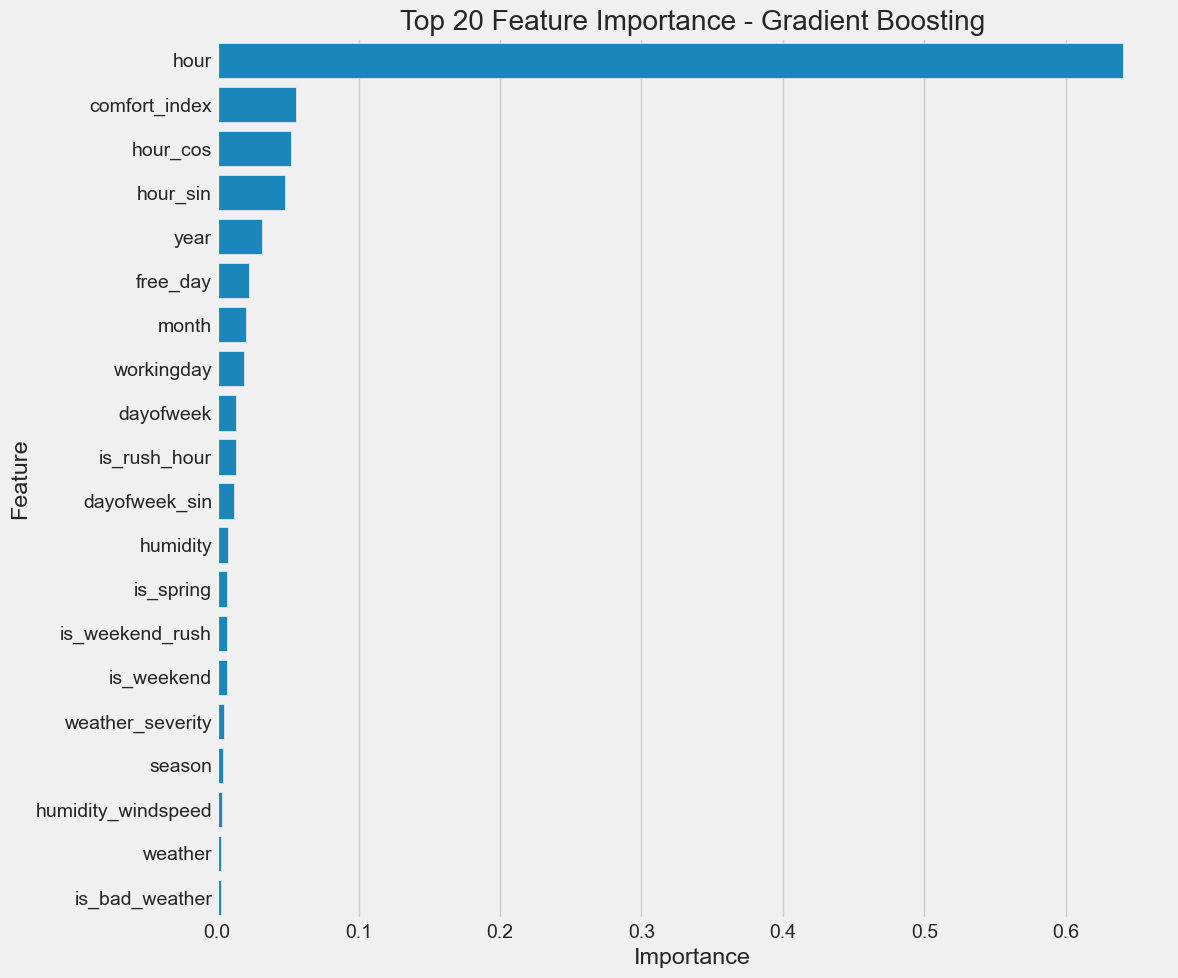


Analysis complete! Check the generated visualizations in the project directory.


In [55]:
# Use the best model for final predictions
print(f"\nFinal model: {best_model_name}")

# Prepare test data
X_test = test_data[features]
X_test_scaled = scaler.transform(X_test)

# Prepare model predictors based on model names
model_predictors = {
    LINEAR_REGRESSION: lambda: np.expm1(lr.predict(X_test_scaled)),
    RIDGE_REGRESSION: lambda: np.expm1(ridge.predict(X_test_scaled)),
    RANDOM_FOREST: lambda: np.expm1(rf.predict(X_test)),
    GRADIENT_BOOSTING: lambda: np.expm1(gb.predict(X_test))
}

final_predictions = model_predictors[best_model_name]()

# Create submission file
submission = pd.DataFrame({
    'datetime': test_data['datetime'],
    'count': final_predictions
})

# Ensure count values are non-negative
submission['count'] = submission['count'].clip(lower=0)

# Save predictions
submission.to_csv('../bike_sharing_predictions.csv', index=False)
print("\nPredictions saved to 'bike_sharing_predictions.csv'")

# Feature importance analysis for tree-based models
if best_model_name in [RANDOM_FOREST, GRADIENT_BOOSTING]:
    best_model = rf if best_model_name == RANDOM_FOREST else gb
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title(f'Top 20 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('../feature_importance.png')
    plt.show()

print("\nAnalysis complete! Check the generated visualizations in the project directory.")

### Feature Importance and Actual vs Predicted

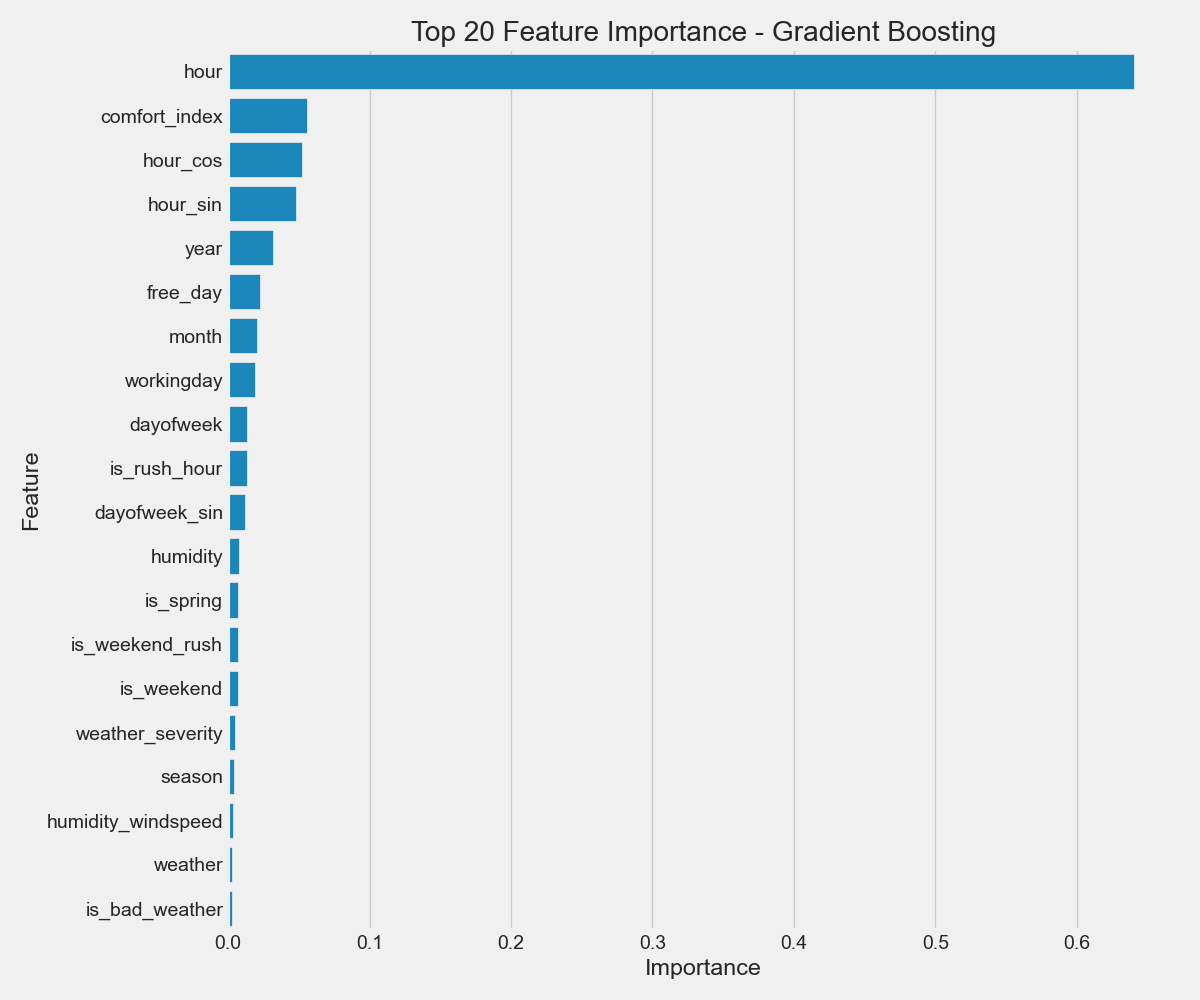

In [56]:
from IPython.display import Image
Image(filename='../feature_importance.png', width=800)

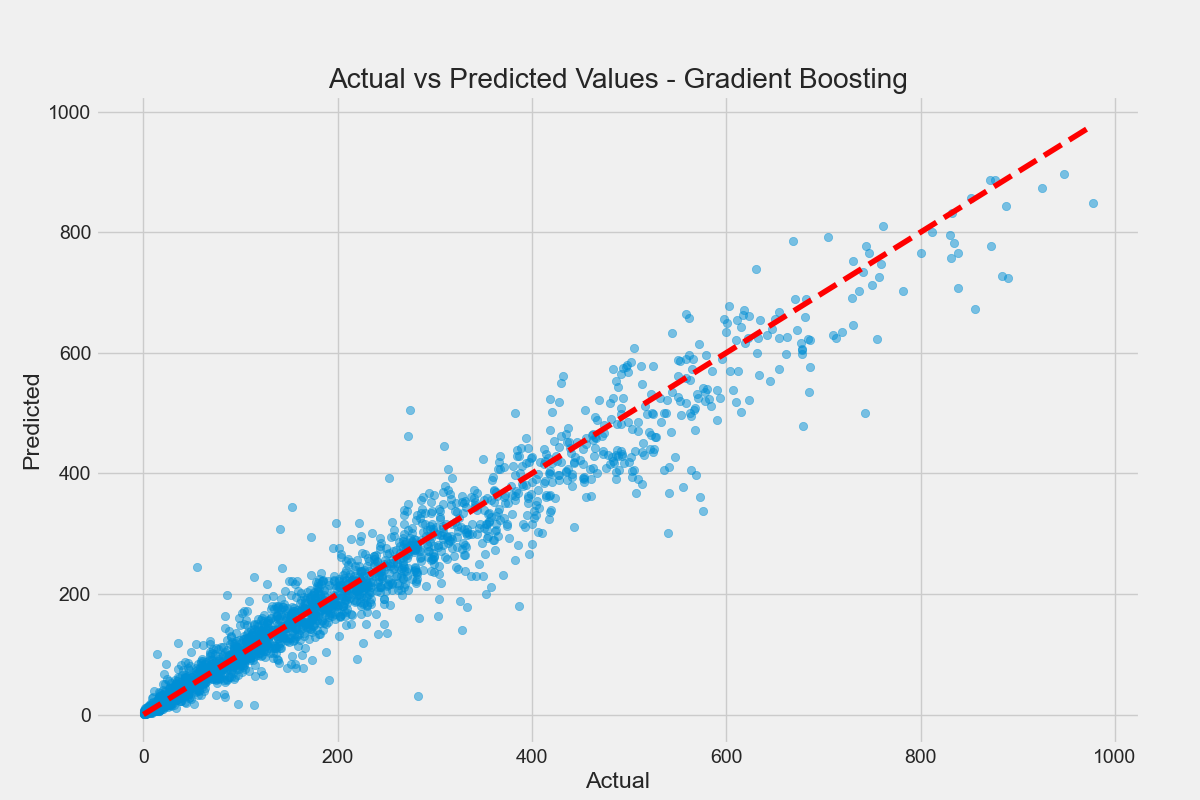

In [57]:
from IPython.display import Image
Image(filename='../actual_vs_predicted.png', width=800)

## Conclusion

Our bike sharing demand prediction model achieves excellent performance using Gradient Boosting as the best model. The key findings include:

1. **Time patterns** are crucial for prediction:
   - Hour of day shows strong bimodal pattern (morning and evening peaks)
   - Weekdays vs. weekends show different usage patterns

2. **Weather factors** significantly impact bike rentals:
   - Temperature is positively correlated with rentals
   - High humidity and precipitation reduce rentals
   - Extreme weather conditions drastically reduce usage

3. **Feature importance** analysis shows:
   - Hour of day is the most important predictor
   - Temperature and season are also highly influential
   - Weather condition and humidity play significant roles

The model effectively captures these patterns and provides accurate predictions for bike rental demand.